In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50

# 本地权重参数
local_weights_file = r'D:\大创\tensorflow\模型参数\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Resnet模型相关设置
pre_trained_model = ResNet50(include_top=False,
                             weights='imagenet',
                             input_shape=(224,224,3)
                             )

# 导入本地权重参数
# pre_trained_model.load_weights(local_weights_file)

# 全部冻结
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [2]:
# 自己选择哪一层作为最后一层
last_layer = pre_trained_model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 2048)


In [3]:
# 回调函数
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

   

In [4]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

# Flatten the output layer to 1 dimension
# 添加扁平层，把last_layer(用户选择的最后一层)拉直
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# 自定义新模型
model = Model( pre_trained_model.input, x)

model.compile(loss = 'binary_crossentropy', optimizer=RMSprop(lr=0.0002), metrics=['accuracy'])

model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

# Define our example directories and files
train_dir = r'D:\大创\img\train'
validation_dir = r'D:\大创\img\test'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,   # 归一化
                                   rotation_range = 40,  # 旋转 0~40°
                                   width_shift_range = 0.2,  # 水平移动 0~ 20%
                                   height_shift_range = 0.2,  # 竖直移动0~20%
                                   shear_range = 0.2,     # 允许剪切，变形
                                   zoom_range = 0.2,        # 缩放0~20%
                                   horizontal_flip = True)  # 水平翻转

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    class_mode = 'binary',
                                                    target_size = (200, 200))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 64,
                                                          class_mode  = 'binary',
                                                          target_size = (200, 200))

# Expected Output:
# Found xxx images belonging to x classes.
# Found xxx images belonging to x classes.

Found 36 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [6]:
callbacks = myCallback()

history = model.fit(
    train_generator, 
    epochs=20,
    # steps_per_epoch=43,   # 5391/128
    validation_data = validation_generator, 
    verbose = 1, 
    # validation_steps=16,  # 1002/64
    # callbacks=[callbacks]
)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.8251 - accuracy: 0.5000 - val_loss: 27.4012 - val_accuracy: 0.5556
Epoch 2/20
1/1 [==============================] - 0s 405ms/step - loss: 26.8045 - accuracy: 0.5556 - val_loss: 6.7351 - val_accuracy: 0.4444
Epoch 3/20
1/1 [==============================] - 0s 406ms/step - loss: 6.6627 - accuracy: 0.4444 - val_loss: 12.2238 - val_accuracy: 0.5556
Epoch 4/20
1/1 [==============================] - 0s 407ms/step - loss: 11.5184 - accuracy: 0.5556 - val_loss: 0.7044 - val_accuracy: 0.5556
Epoch 5/20
1/1 [==============================] - 0s 408ms/step - loss: 1.2561 - accuracy: 0.5000 - val_loss: 0.7263 - val_accuracy: 0.5556
Epoch 6/20
1/1 [==============================] - 0s 408ms/step - loss: 0.9759 - accuracy: 0.6389 - val_loss: 3.6551 - val_accuracy: 0.4444
Epoch 7/20
1/1 [==============================] - 0s 409ms/step - loss: 2.7616 - accuracy: 0.4722 - val_loss: 6.0970 - val_accuracy: 0.5556
Epoch 8/20
1/1 [===

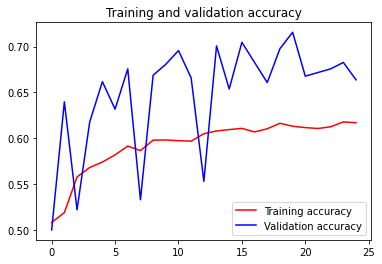

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
import numpy as np
# from google.colab import files
from tensorflow.keras.preprocessing import image

# uploaded = files.upload()

# for fn in uploaded.keys():
 
# predicting images
path = r''
img = image.load_img(path, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)   # 扩展一个维度

# images = np.vstack([x])  # 按竖直方向堆叠
# classes = model.predict(images, batch_size=10)
classes = model.predict([x], batch_size=10)

print(path)
print(classes)

In [23]:
import os
import numpy as np
import numpy as np
# from google.colab import files
from tensorflow.keras.preprocessing import image

dir_name = r'D:\大创\img\train\非萎缩性 胃炎 皮化生'
_dir = os.path.join(dir_name)
files = os.listdir(_dir)

for image in files:
    print(image)
    
    
# img = image.load_img(path, target_size=(200, 200))
# print('img: ' + str(img))

# x = image.img_to_array(img)
# print('x: '+ str(x))
# print('x: '+ str(x.shape))
# x = np.expand_dims(x, axis=0)   # 扩展一个维度
# print('x: ' + str(x))
# print('x: '+ str(x.shape))


刘孝红_102428761.jpg
刘建忠_116604959.jpg
刘昌赟_117310681.jpg
刘昌赟_117310688.jpg
刘本勤_92173757.jpg
利积恩_115887791.jpg
利积恩_115888077.jpg
叶伟明_116911840.jpg
吴婵吟_115548860.jpg
周亚平_118600313.jpg
李柯_116176160.jpg
李秋方_117912134.jpg
蔡小燕_102453379.jpg
蔡远志_115224401.jpg
陈丞_118907543.jpg
马翔_118373525.jpg
